In [ ]:
# !pip install mlxtend
# !pip install imblearn

In [24]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, roc_curve)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import copy
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [25]:
df.head()

,start_dt,end_dt,sender_name,sender_email,theme,descr,sender_name_cut,texts_cmb,topic,cluster
0,01.01.2023 11:22,01.01.2023 22:14,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,. Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА...,content_problem,"['жалоба', 'абонент', 'просьба', 'ответ', 'зап...",9,2
1,01.01.2023 14:18,01.01.2023 22:18,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
2,01.01.2023 15:31,01.01.2023 21:52,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
3,01.01.2023 16:15,01.01.2023 21:51,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
4,01.01.2023 16:15,01.01.2023 21:52,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1


In [47]:
df = pd.read_csv('labelled_data_1.csv', index_col=False)
df.drop(columns=['Unnamed: 0.1', 'Column1', 'Unnamed: 0'], inplace=True)

In [31]:
df.cluster.value_counts(normalize=True)

cluster
1     0.406573
4     0.191918
9     0.118745
6     0.072379
5     0.048848
3     0.042494
10    0.036835
7     0.033062
8     0.032069
2     0.017077
Name: proportion, dtype: float64

In [48]:
df.drop(df[df.cluster == '?'].index, inplace=True)

In [50]:
df['cluster'].notna().sum()

10072

In [51]:
df = df[df['cluster'].notna()]

Классы в датасете не сбалансированы. 5 тема - 50% всего датасета.
1. Обращения
   1.1 Списания/денежные средства
   1.2 Проблемы с сим-меню
   1.3 Esim (проблемы подключения, код активации, qr-код)
   1.4 Проблемы с контентом и отключение услуг/ подписок/ сервисов
   1.5 Учетные записи
2. Информация
   2.6 Уведомления о технических работах
   2.7 Сбой работы (в работе оператора)
   2.8 Тесты, проблемы с доставкой, прочие тех. оповещения
3. Черный список
   3.9 Черный список
4. Спам
   4.10 Спам, реклама

## Word2Vec

In [52]:
w2v_model = gensim.models.Word2Vec.load("word2vec.model")

df.texts_cmb = df.texts_cmb.astype(str)
texts_tokenized = [text.split() for text in df['texts_cmb']]

In [53]:
def get_mean_vector(text):
    words = [w for w in text if w in w2v_model.wv]
    return np.mean(w2v_model.wv[words], axis=0) if words else np.zeros(w2v_model.vector_size)

df['mean_vector'] = df['texts_cmb'].apply(lambda x: get_mean_vector(x))

In [34]:
with pd.option_context('display.max_colwidth', None):
    display(df[df['cluster'] == '4'][['descr']])

,descr
10,Добрый день! Прошу отключить абоненту 992929146979 все услуги. По его словам не отключается – уточните плз причину. BR Shavkat
11,"Добрый день! Коллеги, поступила жалоба от абонента на услугу «Живой баланс». Просьба проверить. 0;Номер абонента;""79023050309""1;Тарифный план и Регион;""Классический v. 1.8 Нижний Новгород""2;Дата активации SIM-карты;""17.09.2022""3;Дата и время возникновения проблемы;""01.10.2022 0:19 мск""4;Описание проблемы (подробно!);""отображается баланс на экране телефона, рекомендации выполнял""5;Операционная си..."
15,Добрый день Прошу отключить контенты на номере 998976160361 С уважением… Ахунджанова Ш.Р ООО «UMS» БПиМ ДАО ОТСО ФГСИПКК IP: 40053 Тел: 97 479 06 05?????
24,"Добрый День! Прошу предоставить данные по подпискам абонента: 998971197919 Дата/время подписки: Способ подписки: Текущий статус подписки: Заранее Спасибо С Уважением, Мирхалилов Миразим Миркомил угли Ведущий Специалист Группы Технической Поддержки, Отдела технического сопровождения обслуживания Universal Mobile Systems e-mail: mmirkhalilov@mobi.uz Тел: +998974038707 +998974240943 &amp;n..."
34,"Добрый день. Просим рассмотреть обращение от пользователя по услуге Семья здесь, ТН 375333575039 С 3-01-2023 при запросе местонахождения № 375-33-337-50-38 с 9:00 и до сих пор нет ответа по местоположению Место положения: г. Мядель Сеть: Н+ и 4G На дисплее идет поиск (прокрутка загрузки). С уважением, Ирина Марачковская Специалист по маркетингу Отдел базовых сервисов и бизнес-продуктов Управление продуктового маркетинга и стратегии СООО «Мобильные ТелеСистемы» ___..."
...,...
10233,"Доброго времени суток! 0. Номер абонента : 79504066912 1. Дата и время заказа : 07:26 03/09/2024 2. Номер провайдера (для КЦ из InVoice / для розницы - номер подписки из WD) : Tele2 3. Описание проблемы : У абонента всплывают push окна о спорте/туризме, ранее приходит ""СМС от Tele2"" и далее окно, использование USSD команды не помогло 4. Текст сообщения на экране телефона (не путать с Tele2 тема) : Push окно о погоде, спорте и т.д ..."
10248,"Здравствуйте!Вы получили это письмо, так как подписаны на его рассылку. Номер телефона, на котором подключена услуга: 87013715568 Номер абонента, с которого поступил вызов (канал – голос/WA): 87013715568 Описание вопроса/проблемы: 87013715568 Название услуги: Кселл - «OGO Удача» - - - Пожалуйста, не отвечайте на это письмо, это автоматическое уведомление. Информация, представленная в письме, предназначена только для внутреннего пользования. SMARTER"
10252,"Добрый вечер Прошу отключить контент услуги 998882519151 -2580 Заранее спасибо! С уважением, Миргиесов Миркомил Миржамол угли Специалист Группы Технической Поддержки, mailto: mmirgiesov@mobi.uz Phone: +998973303787 Mobiuz"
10256,"UMS - отключенные номера за 28-09-2024Просьба проверить на наличие подписок. В случае обнаружения подписок на любые услуги, все подписки следует отключить."


## SVM

In [59]:
X = np.array([get_mean_vector(text) for text in df['texts_cmb']])
y = df['topic'].astype('int')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [61]:
# Посмотрим на рапределение классов в тесте и трейне
print('y_train', y_train.value_counts(normalize=True))
print('y_test', y_test.value_counts(normalize=True))

y_train topic
5    0.476569
2    0.110405
1    0.092931
3    0.071882
0    0.049643
4    0.046465
6    0.044480
9    0.044083
7    0.038920
8    0.024623
Name: proportion, dtype: float64
y_test topic
5    0.479746
2    0.113450
1    0.086444
3    0.067249
0    0.053614
4    0.045671
9    0.041700
6    0.041303
7    0.036802
8    0.034022
Name: proportion, dtype: float64


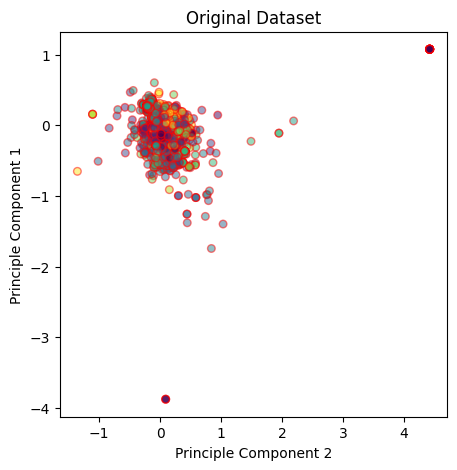

In [62]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(1, 0, 0, 0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

In [63]:
# Создаем модель SVM для многоклассовой классификации
svm_model = SVC(kernel='linear', decision_function_shape='ovr')

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred))

Точность классификации: 0.8475

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.67      0.82      0.74       405
           1       0.75      0.94      0.84       653
           2       0.75      0.83      0.79       857
           3       0.65      0.76      0.70       508
           4       0.54      0.28      0.37       345
           5       0.99      1.00      0.99      3624
           6       0.89      0.55      0.68       312
           7       0.74      0.79      0.77       278
           8       0.89      0.65      0.75       257
           9       0.53      0.28      0.37       315

    accuracy                           0.85      7554
   macro avg       0.74      0.69      0.70      7554
weighted avg       0.84      0.85      0.84      7554



### Random Oversampling

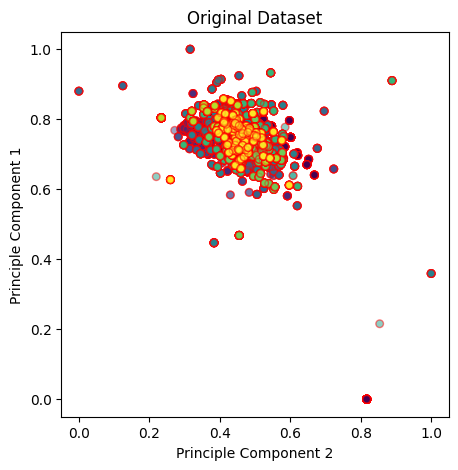

In [64]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_ros, y_train_ros, ax, title='Original Dataset')

In [65]:
# Train SVC on randomly oversampled data
clf_ros = SVC(kernel='linear', decision_function_shape='ovr')
clf_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = clf_ros.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_ros)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_ros))

Точность классификации: 0.8711

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       405
           1       0.84      0.85      0.85       653
           2       0.90      0.77      0.83       857
           3       0.80      0.73      0.76       508
           4       0.40      0.48      0.44       345
           5       0.99      0.99      0.99      3624
           6       0.78      0.63      0.70       312
           7       0.76      0.84      0.80       278
           8       0.83      0.84      0.83       257
           9       0.60      0.70      0.65       315

    accuracy                           0.87      7554
   macro avg       0.77      0.77      0.77      7554
weighted avg       0.88      0.87      0.87      7554



## Undersampling

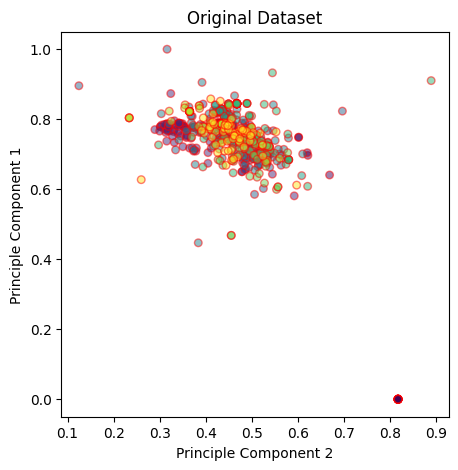

In [66]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_rus, y_train_rus, ax, title='Original Dataset')

In [67]:
# Train SVC on randomly undersampled data
clf_rus  = SVC(kernel='linear', decision_function_shape='ovr')
clf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = clf_rus.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8205

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.62      0.74      0.67       405
           1       0.77      0.84      0.81       653
           2       0.75      0.69      0.72       857
           3       0.69      0.72      0.70       508
           4       0.41      0.35      0.38       345
           5       0.99      0.96      0.97      3624
           6       0.79      0.56      0.65       312
           7       0.60      0.81      0.69       278
           8       0.69      0.74      0.72       257
           9       0.59      0.66      0.62       315

    accuracy                           0.82      7554
   macro avg       0.69      0.71      0.69      7554
weighted avg       0.83      0.82      0.82      7554



## Class weights


In [68]:
# Train SVC on default data
clf_bal = SVC(kernel='linear', class_weight='balanced')
clf_bal.fit(X_train, y_train)
y_pred_rus = clf_bal.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8611

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.65      0.88      0.75       405
           1       0.82      0.88      0.85       653
           2       0.91      0.75      0.82       857
           3       0.74      0.71      0.72       508
           4       0.44      0.43      0.43       345
           5       0.99      0.99      0.99      3624
           6       0.83      0.56      0.67       312
           7       0.71      0.82      0.76       278
           8       0.82      0.83      0.83       257
           9       0.58      0.67      0.62       315

    accuracy                           0.86      7554
   macro avg       0.75      0.75      0.74      7554
weighted avg       0.87      0.86      0.86      7554



Наилучший результат показала модель на oversampled data - 0.8711